<img src="header.png" align="left"/>

# Anwendungsbeispiel Import of excel data and timeseries prediction

Das Ziel dieses Beispieles ist es die Arbeit mit Zeitreihen aus Excel Files zu zeigen und darauf ein Vorhersagemodell für Zeitreihen zu entwickeln. Der Datensatz beschreibt die Entwicklung von Flugpassagierzahlen einer Airline in der fernen Vergangenheit. Die Daten sind aber typisch für Daten wie sie KMUs (z.B. Verkaufszahlen) zu finden sind. 


Der Code für das Beispiel wurde aus [1] adaptiert. Weitergehende Informationen sind zum Beispiel in [2] zu finden. 

- [1] [https://machinelearningmastery.com/time-series-prediction-lstm-recurrent-neural-networks-python-keras/](https://machinelearningmastery.com/time-series-prediction-lstm-recurrent-neural-networks-python-keras/)
- [2] [https://towardsdatascience.com/predict-electricity-consumption-using-time-series-analysis-4650284e40aa](https://towardsdatascience.com/predict-electricity-consumption-using-time-series-analysis-4650284e40aa)


Zitierung Datensatz:
```
Box, G. E. P., Jenkins, G. M. and Reinsel, G. C. (1976) Time Series Analysis, Forecasting and Control. Third Edition. Holden-Day. Series G.
```


# Import der Module

In [1]:
#
# Import der Module
#
import os
import logging
import openpyxl

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math

import sklearn
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error


#
# Abdrehen von Fehlermeldungen
#
from warnings import simplefilter
# ignore all future warnings
simplefilter(action='ignore', category=FutureWarning)
simplefilter(action='ignore', category=Warning)
simplefilter(action='ignore', category=RuntimeWarning)


#
# Tensorflow und Keras
#
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM


#
# Für GPU Support
#
tflogger = tf.get_logger()
tflogger.setLevel(logging.ERROR)
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR )
physical_devices = tf.config.experimental.list_physical_devices('GPU')
if len(physical_devices) > 0:
    tf.config.experimental.set_memory_growth(physical_devices[0], True)


#
# Einstellen der Grösse von Diagrammen
#
plt.rcParams['figure.figsize'] = [16, 9]


#
# Ausgabe der Versionen
#
print('working on keras version {} on tensorflow {} using sklearn {}'.format ( tf.keras.__version__, tf.version.VERSION, sklearn.__version__ ) )

working on keras version 2.2.4-tf on tensorflow 2.1.0 using sklearn 0.23.2


# Konstanten

In [2]:
#
# Konstanten für Dateien
#
excelData = 'data/airline_passengers.xlsx'

In [3]:
data = pd.ExcelFile(excelData)
print(data.sheet_names)

['Tabellenblatt1']


In [4]:
#
# Auslesen eines Tabellenblattes
#
df = data.parse('Tabellenblatt1')
df.info
df.head(10)

,Unnamed: 0,Unnamed: 1,Unnamed: 2
0,NaN,NaN,NaN
1,NaN,NaN,NaN
2,NaN,Month,Passengers
3,NaN,1949-01-01 00:00:00,112
4,NaN,1949-02-01 00:00:00,118
5,NaN,1949-03-01 00:00:00,132
6,NaN,1949-04-01 00:00:00,129
7,NaN,1949-05-01 00:00:00,121
8,NaN,1949-06-01 00:00:00,135
9,NaN,1949-07-01 00:00:00,148


In [5]:
df.tail()

,Unnamed: 0,Unnamed: 1,Unnamed: 2
142,NaN,1960-08-01 00:00:00,606
143,NaN,1960-09-01 00:00:00,508
144,NaN,1960-10-01 00:00:00,461
145,NaN,1960-11-01 00:00:00,390
146,NaN,1960-12-01 00:00:00,432


# Ausschneiden von Daten in pandas dataframes

Ein sehr gutes Tutorial dazu kann hier gefunden werden: [https://www.shanelynn.ie/select-pandas-dataframe-rows-and-columns-using-iloc-loc-and-ix/](https://www.shanelynn.ie/select-pandas-dataframe-rows-and-columns-using-iloc-loc-and-ix/)

<img src="info.png" align="left"/> 

In [6]:
#
# Ausschneiden der benötigten Daten
#
df_cut = df.iloc[3:146,1:3]

In [7]:
df_cut.head()

,Unnamed: 1,Unnamed: 2
3,1949-01-01 00:00:00,112
4,1949-02-01 00:00:00,118
5,1949-03-01 00:00:00,132
6,1949-04-01 00:00:00,129
7,1949-05-01 00:00:00,121


In [8]:
df_cut.columns = ['month','passengers']

In [9]:
df_cut.head()

,month,passengers
3,1949-01-01 00:00:00,112
4,1949-02-01 00:00:00,118
5,1949-03-01 00:00:00,132
6,1949-04-01 00:00:00,129
7,1949-05-01 00:00:00,121


<AxesSubplot:>

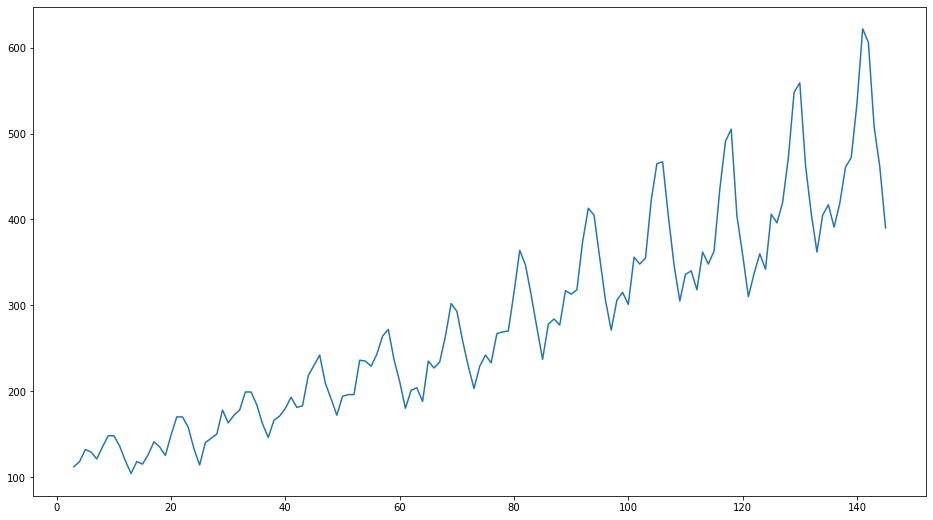

In [10]:
df_cut['passengers'].plot()

# Konventionelle Arbeit mit solchen Zeitreihen

Es gibt eine Reihe von älteren Methoden um mit solchen Zeitreihen umzugehen und auch gute Ergebnisse bei der Vorhersage zu erreichen. Beispiele dazu sind hier zu finden:

- https://machinelearningmastery.com/time-series-trends-in-python/
- https://towardsdatascience.com/predict-electricity-consumption-using-time-series-analysis-4650284e40aa


Die wesentliche Leistung dieser Verfahren ist die Berechnung und Verwendung von Parameters wie **Trend** und **Saisonalität**. Wir hoffen, dass unsere Modelle damit umgehen können, ohne dass wir uns explizit darum kümmern müssen.


<img src="info.png" align="left"/> 

In [11]:
x_data = df_cut['passengers'].values
x_data = x_data.astype('float32')
x_data = np.reshape(x_data,(-1,1))
print(x_data)

[[112.]
 [118.]
 [132.]
 [129.]
 [121.]
 [135.]
 [148.]
 [148.]
 [136.]
 [119.]
 [104.]
 [118.]
 [115.]
 [126.]
 [141.]
 [135.]
 [125.]
 [149.]
 [170.]
 [170.]
 [158.]
 [133.]
 [114.]
 [140.]
 [145.]
 [150.]
 [178.]
 [163.]
 [172.]
 [178.]
 [199.]
 [199.]
 [184.]
 [162.]
 [146.]
 [166.]
 [171.]
 [180.]
 [193.]
 [181.]
 [183.]
 [218.]
 [230.]
 [242.]
 [209.]
 [191.]
 [172.]
 [194.]
 [196.]
 [196.]
 [236.]
 [235.]
 [229.]
 [243.]
 [264.]
 [272.]
 [237.]
 [211.]
 [180.]
 [201.]
 [204.]
 [188.]
 [235.]
 [227.]
 [234.]
 [264.]
 [302.]
 [293.]
 [259.]
 [229.]
 [203.]
 [229.]
 [242.]
 [233.]
 [267.]
 [269.]
 [270.]
 [315.]
 [364.]
 [347.]
 [312.]
 [274.]
 [237.]
 [278.]
 [284.]
 [277.]
 [317.]
 [313.]
 [318.]
 [374.]
 [413.]
 [405.]
 [355.]
 [306.]
 [271.]
 [306.]
 [315.]
 [301.]
 [356.]
 [348.]
 [355.]
 [422.]
 [465.]
 [467.]
 [404.]
 [347.]
 [305.]
 [336.]
 [340.]
 [318.]
 [362.]
 [348.]
 [363.]
 [435.]
 [491.]
 [505.]
 [404.]
 [359.]
 [310.]
 [337.]
 [360.]
 [342.]
 [406.]
 [396.]
 [420.]


In [12]:
#
# Normalize the dataset
#
scaler = MinMaxScaler(feature_range=(0.0, 1.0))
scaler.fit(x_data)

MinMaxScaler(feature_range=(0.0, 1.0))

In [13]:
print(scaler.data_max_)

[622.]


In [14]:
x_data = scaler.transform(x_data)
print(x_data)

[[0.01544401]
 [0.02702703]
 [0.05405405]
 [0.04826255]
 [0.03281853]
 [0.05984557]
 [0.08494207]
 [0.08494207]
 [0.06177607]
 [0.02895753]
 [0.        ]
 [0.02702703]
 [0.02123553]
 [0.04247104]
 [0.07142857]
 [0.05984557]
 [0.04054055]
 [0.08687258]
 [0.12741312]
 [0.12741312]
 [0.10424709]
 [0.05598456]
 [0.01930502]
 [0.06949806]
 [0.07915059]
 [0.08880308]
 [0.14285713]
 [0.11389962]
 [0.13127413]
 [0.14285713]
 [0.18339768]
 [0.18339768]
 [0.15444016]
 [0.11196911]
 [0.08108109]
 [0.1196911 ]
 [0.12934363]
 [0.14671814]
 [0.17181468]
 [0.14864865]
 [0.15250966]
 [0.22007722]
 [0.24324325]
 [0.26640925]
 [0.2027027 ]
 [0.16795367]
 [0.13127413]
 [0.17374519]
 [0.17760617]
 [0.17760617]
 [0.25482625]
 [0.25289574]
 [0.24131274]
 [0.26833975]
 [0.3088803 ]
 [0.32432434]
 [0.25675675]
 [0.20656371]
 [0.14671814]
 [0.18725869]
 [0.19305018]
 [0.16216215]
 [0.25289574]
 [0.23745173]
 [0.25096524]
 [0.3088803 ]
 [0.38223937]
 [0.36486486]
 [0.2992278 ]
 [0.24131274]
 [0.1911197 ]
 [0.24

In [15]:
# split into train and test sets
train_size = int(len(x_data) * 0.80)
test_size = len(x_data) - train_size
train, test = x_data[0:train_size,:], x_data[train_size:len(x_data),:]
print(len(train), len(test))

114 29


# Erzeugen eines Trainingsdatensatzes mit Hilfe von sliding windows

Sliding windows werden aus einer Zeitreihe erzeugt, indem ein Fenster über die gesamte Zeitreihe gezogen wird und dabei jeweils die Daten im Fenster kopiert werden. Mehr Details dazu hier [https://towardsdatascience.com/ml-approaches-for-time-series-4d44722e48fe](https://towardsdatascience.com/ml-approaches-for-time-series-4d44722e48fe).

<img src="info.png" align="left"/> 

In [16]:
#
# Transformation einer Zeitreihe in sliding windows mit einem label (y)
#
def createSlidingWindowsWithLabel(dataset, look_back=1):
    dataX, dataY = [], []
    for i in range(len(dataset)-look_back-1):
        a = dataset[ i:(i+look_back), 0]
        dataX.append(a)
        dataY.append(dataset[i + look_back, 0])
    return np.array(dataX), np.array(dataY)

In [17]:
#
# Anwenden der sliding window Funktion
#
look_back = 1
trainX, trainY = createSlidingWindowsWithLabel(train, look_back)
testX, testY = createSlidingWindowsWithLabel(test, look_back)

In [18]:
# 
# reshape input to be [samples, time steps, features]
#
trainX = np.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
testX = np.reshape(testX, (testX.shape[0], 1, testX.shape[1]))

In [19]:
#
# create and fit the LSTM network
#
def createLSTMModel():
    model = Sequential()
    model.add(LSTM(10, input_shape=(1, look_back)))
    model.add(Dense(1,activation='linear'))
    model.compile(loss='mean_squared_error', optimizer='adam')
    return model

In [20]:
lstm_model = createLSTMModel()

In [21]:
lstm_model.fit(trainX, trainY, epochs=40, batch_size=1, verbose=1)

Train on 112 samples
Epoch 1/40
112/112 [==============================] - 4s 38ms/sample - loss: 0.0718
Epoch 2/40
112/112 [==============================] - 0s 4ms/sample - loss: 0.0315
Epoch 3/40
112/112 [==============================] - 1s 7ms/sample - loss: 0.0232
Epoch 4/40
112/112 [==============================] - 1s 5ms/sample - loss: 0.0206
Epoch 5/40
112/112 [==============================] - 0s 4ms/sample - loss: 0.0179
Epoch 6/40
112/112 [==============================] - 0s 4ms/sample - loss: 0.0157
Epoch 7/40
112/112 [==============================] - 1s 6ms/sample - loss: 0.0131
Epoch 8/40
112/112 [==============================] - 1s 5ms/sample - loss: 0.0109
Epoch 9/40
112/112 [==============================] - 1s 6ms/sample - loss: 0.0088
Epoch 10/40
112/112 [==============================] - 1s 5ms/sample - loss: 0.0068
Epoch 11/40
112/112 [==============================] - 0s 4ms/sample - loss: 0.0051
Epoch 12/40
112/112 [==============================] - 0s 4ms/s

In [22]:
#
# Schätzung der Werte für train und test Daten
#
trainPredict = lstm_model.predict(trainX)
testPredict = lstm_model.predict(testX)

In [23]:
#
# Rücktransformation der Schätzungen (scaler)
#
trainPredict = scaler.inverse_transform(trainPredict)
trainYi = scaler.inverse_transform([trainY])
testPredict = scaler.inverse_transform(testPredict)
testYi = scaler.inverse_transform([testY])

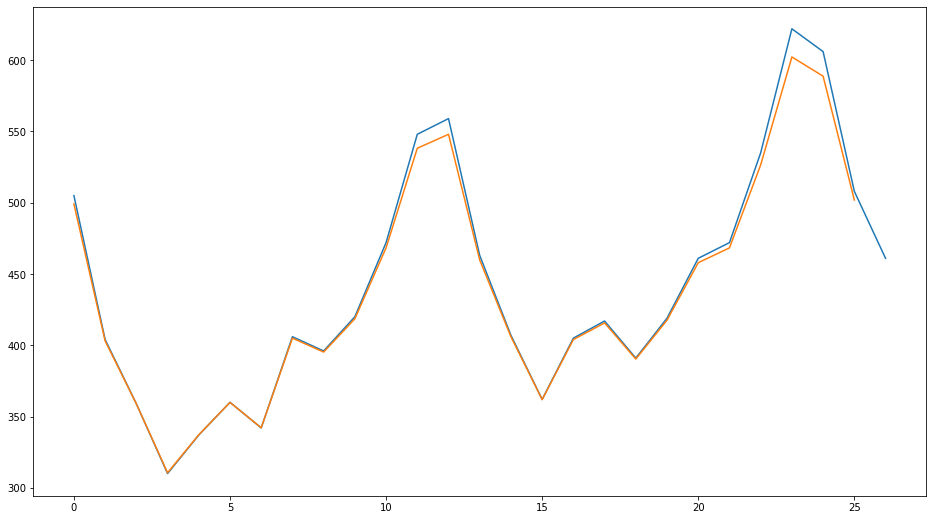

In [24]:
#
# Anzeige der geschätzten neuen Werte
#
plt.plot(testYi[0,0:])
plt.plot(testPredict[1:,0])
plt.show()

In [25]:
# calculate root mean squared error
trainScore = math.sqrt(mean_squared_error(trainYi[0,0:-1], trainPredict[1:,0]))
print('train loss: %.3f RMSE' % (trainScore))
testScore = math.sqrt(mean_squared_error(testYi[0,0:-1], testPredict[1:,0]))
print('test loss: %.3f RMSE' % (testScore))

train loss: 4.980 RMSE
test loss: 6.522 RMSE


In [26]:
# shift train predictions for plotting
trainPredictPlot = np.empty_like(x_data)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[:len(trainPredict)+0, :] = trainPredict

# shift test predictions for plotting
testPredictPlot = np.empty_like(x_data)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(trainPredict)+(look_back*2):len(x_data)-2, :] = testPredict

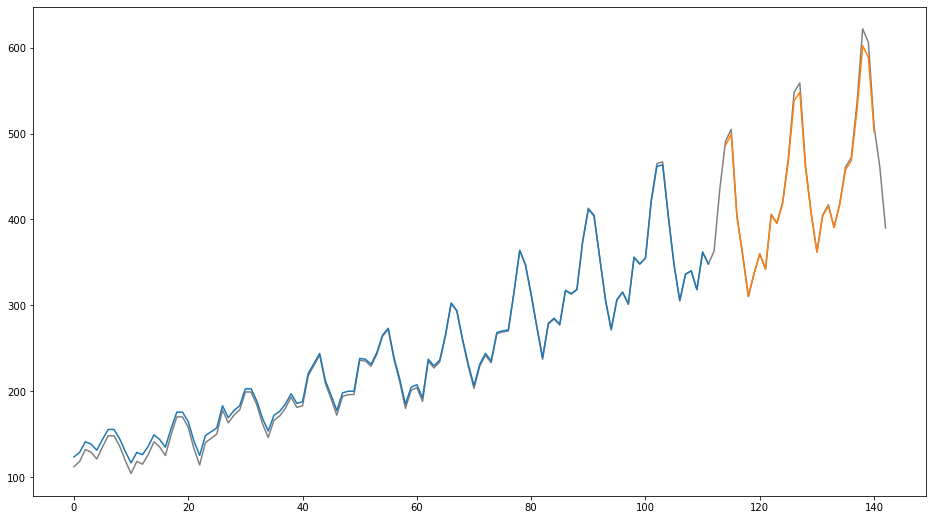

In [27]:
# plot baseline and predictions
plt.plot(scaler.inverse_transform(x_data), color='grey')
plt.plot(trainPredictPlot)
plt.plot(testPredictPlot)
plt.show()

## Welche Verbesserungsschritte wären sonst noch möglich?

<img src="info.png" align="left"/> 